In [2]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric
from utils.feature_contena import Features
from utils.pandas_utils import reduce_mem_usage

In [3]:
config = f"""
execution:
    exp_id: exp_043
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [4]:
sub = pd.read_csv(os.path.join(CFG["output_dir"], "submission.csv"))

In [5]:
sub

,series_id,key_step,event,score,step
0,038441c925bb,5075.5,onset,0.803890,5063
1,038441c925bb,10907.5,wakeup,0.823391,10895
2,038441c925bb,20723.5,onset,0.367548,20711
3,038441c925bb,23675.5,wakeup,0.126920,23663
4,038441c925bb,23843.5,onset,-0.009228,23831
...,...,...,...,...,...
11413,fe90110788d2,547115.5,wakeup,0.777873,547103
11414,fe90110788d2,556619.5,onset,0.903420,556607
11415,fe90110788d2,560939.5,wakeup,0.917187,560927
11416,fe90110788d2,574763.5,onset,0.835909,574751


In [6]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


In [9]:
scores = []
for _ in tqdm(range(100)):
    size = 50
    series_ids = random.sample(list(labels["series_id"].unique()), size)
    labels_sample = labels[labels["series_id"].isin(series_ids)]
    sub_sample = sub[sub["series_id"].isin(series_ids)]

    score = compute_comptetition_metric(labels_sample, sub_sample)[0]
    scores.append(score)

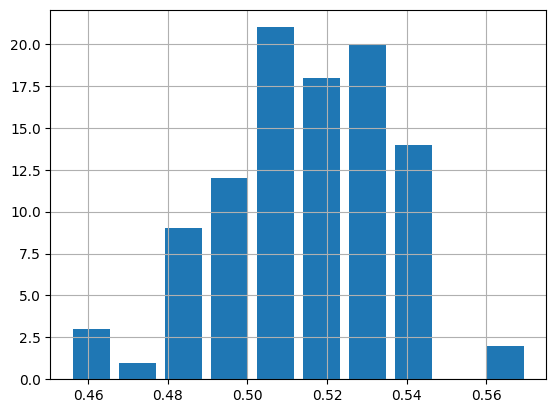

In [12]:
plt.hist(scores, bins=10, rwidth=0.8)
plt.grid()
plt.show()